In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from deepxde.backend import tf

import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
ub = 200
rb = 20


def func(t, r):
    x, y = r
    dx_t = 1 / ub * rb * (2.0 * ub * x - 0.04 * ub * x * ub * y)
    dy_t = 1 / ub * rb * (0.02 * ub * x * ub * y - 1.06 * ub * y)
    return dx_t, dy_t


def gen_truedata():
    t = np.linspace(0, 1, 100)

    sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)
    x_true, y_true = sol.y
    x_true = x_true.reshape(100, 1)
    y_true = y_true.reshape(100, 1)

    return x_true, y_true


def ode_system(x, y):

    r = y[:, 0:1]
    p = y[:, 1:2]
    dr_t = dde.grad.jacobian(y, x, i=0)
    dp_t = dde.grad.jacobian(y, x, i=1)

    return [
        dr_t - 1 / ub * rb * (2.0 * ub * r - 0.04 * ub * r * ub * p),
        dp_t - 1 / ub * rb * (0.02 * r * ub * p * ub - 1.06 * p * ub),
    ]

geom = dde.geometry.TimeDomain(0, 1.0)
data = dde.data.PDE(geom, ode_system, [], 3000, 2, num_test=3000)

layer_size = [1] + [64] * 6 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )

def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    return tf.concat([y1 * tf.tanh(t) + 100 / ub, y2 * tf.tanh(t) + 15 / ub], axis=1)



In [28]:
geom.boundary_normal(4)

0.0

In [19]:
dde.Model()

deepxde.model.Model

In [28]:
t = np.linspace(0, 1, 100)

sol = integrate.solve_ivp(func, (0, 10), (100 / ub, 15 / ub), t_eval=t)


In [36]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.010e-02 ...  9.899e-01  1.000e+00]
        y: [[ 5.000e-01  6.533e-01 ...  2.971e-01  4.043e-01]
            [ 7.500e-02  9.643e-02 ...  5.746e-02  6.147e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3182
     njev: 0
      nlu: 0

In [35]:
func((1,2),(10,20))

(-31600.0, 15576.0)

In [29]:
x_true, y_true = sol.y
x_true = x_true.reshape(100, 1)
y_true = y_true.reshape(100, 1)

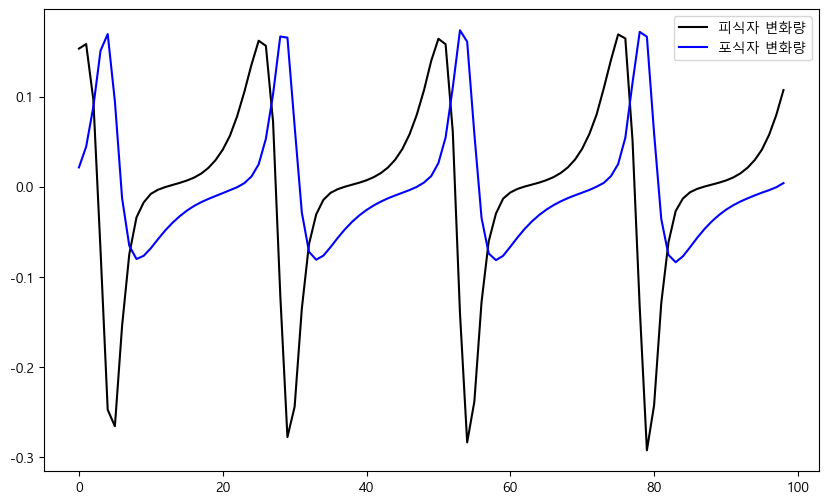

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(np.diff(x_true, n=1, axis=0), 'k-', label = '피식자 변화량')
plt.plot(np.diff(y_true, n=1, axis=0), 'b-', label = '포식자 변화량')
plt.legend()
plt.show()

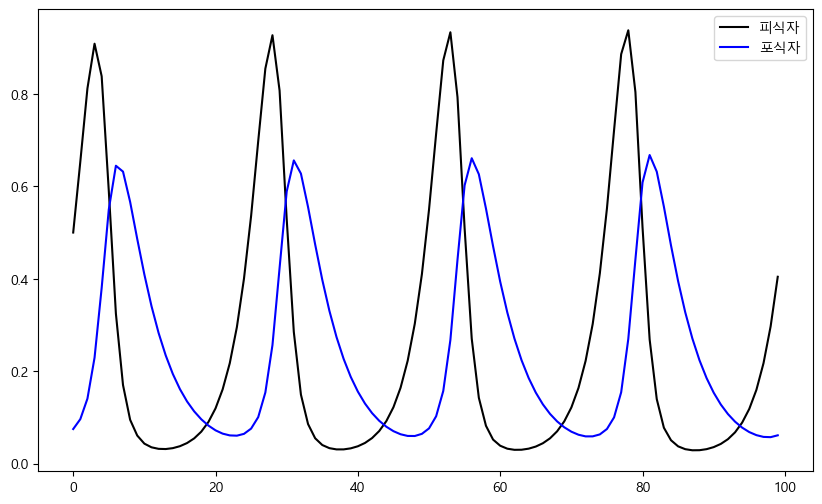

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(x_true, 'k-', label='피식자')
plt.plot(y_true, 'b-', label='포식자')
plt.legend()
plt.show()

In [3]:
net.apply_feature_transform(input_transform)
net.apply_output_transform(output_transform)

Compiling model...
'compile' took 0.598925 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.65e+02, 2.78e+01]    [1.65e+02, 2.78e+01]    []  
1000      [5.43e+00, 5.68e-01]    [5.30e+00, 5.66e-01]    []  
2000      [2.77e+00, 6.11e-01]    [2.65e+00, 6.02e-01]    []  
3000      [1.68e+00, 7.36e-01]    [1.59e+00, 7.20e-01]    []  
4000      [1.07e+00, 7.16e-01]    [1.00e+00, 6.97e-01]    []  
5000      [6.56e-01, 6.34e-01]    [6.16e-01, 6.14e-01]    []  
6000      [4.34e-01, 5.23e-01]    [4.09e-01, 5.06e-01]    []  
7000      [3.13e-01, 4.30e-01]    [2.98e-01, 4.16e-01]    []  
8000      [2.30e-01, 3.49e-01]    [2.20e-01, 3.36e-01]    []  
9000      [1.88e-01, 3.01e-01]    [1.81e-01, 2.90e-01]    []  
10000     [1.52e-01, 2.64e-01]    [1.47e-01, 2.55e-01]    []  
11000     [1.33e-01, 2.38e-01]    [1.30e-01, 2.30e-01]    []  
12000     [1.29e-01, 2.20e-01]    [1.27e-01, 2.13e-01]    []  

Best model at step 12000:
  train loss: 3.49e

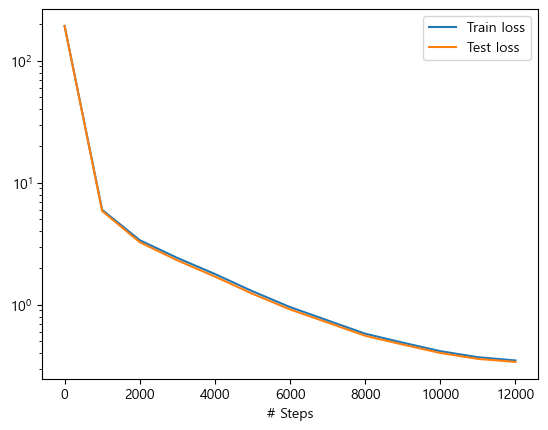

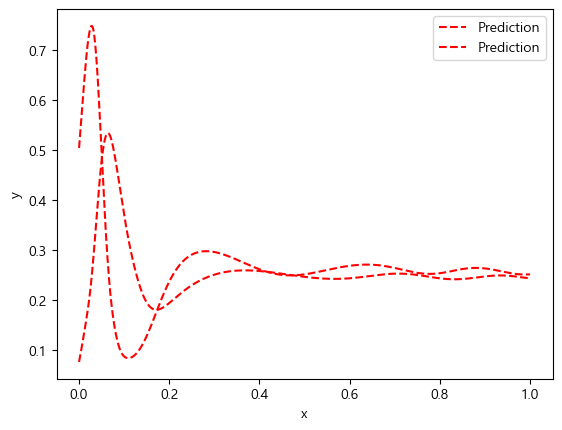

In [74]:
model = dde.Model(data, net)
model.compile("adam", lr=0.0001)
losshistory, train_state = model.train(iterations=12000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [75]:
x_true, y_true = gen_truedata()

t = np.linspace(0, 1, 100)

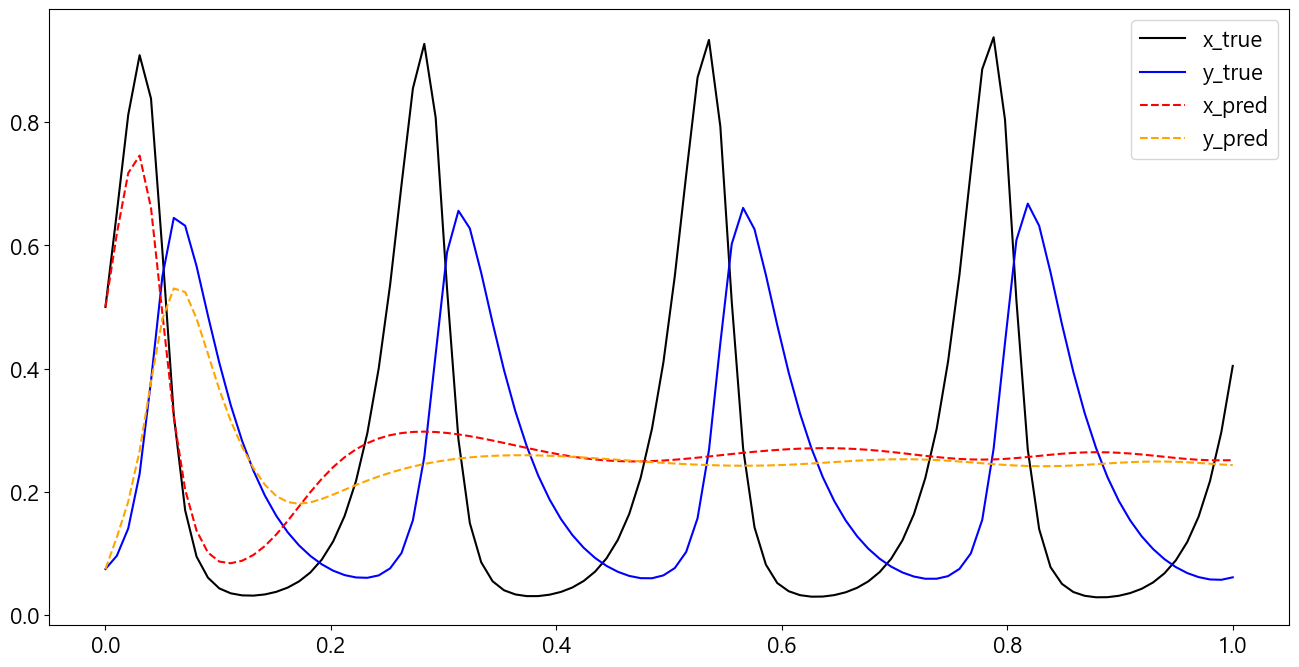

In [76]:
plt.figure(figsize=(16, 8))

plt.plot(t, x_true, color="black", label="x_true")
plt.plot(t, y_true, color="blue", label="y_true")

t = t.reshape(100, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred")
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()